# [IAPR 2019:][iapr2019] Lab 2 ‒  Object description

**Author:** first name and last name  
**Due date:** 19.04.2019

[iapr2019]: https://github.com/LTS5/iapr-2019

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Description
In the `lab-02-data/` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

In [26]:
import skimage.io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from scipy.ndimage import sobel
import cv2
from skimage import feature
from skimage import transform
from skimage import measure
import scipy.ndimage as nd
from scipy.fftpack import fft, ifft
from sklearn import svm
import math

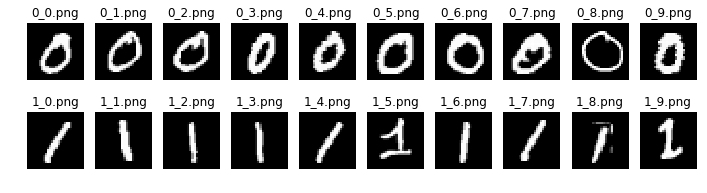

In [3]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors
Let's try first to detect the contours of each image as we did in the lab1

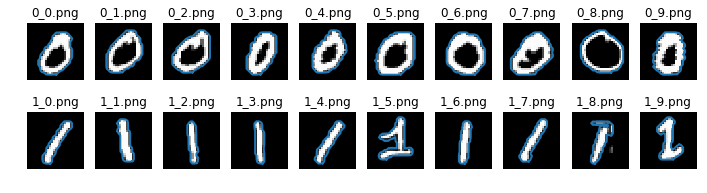

In [4]:
#for the zeros 
feature_descriptors_zero=np.zeros((10,2))
feature_descriptors_one=np.zeros((10,2))
i=0;
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    zero_contour=measure.find_contours(im,10) 
    # let's compute the complex signal based on the contours
    complex_signal_zero=zero_contour[0][:,0] + 1j*(zero_contour[0][:,1])
    # Now let's compute the fft signal 
    fourier_transform_zero=fft(complex_signal_zero)
    feature_descriptors_zero[i,0]=np.abs(fourier_transform_zero[1])
    feature_descriptors_zero[i,1]=np.abs(fourier_transform_zero[2])
    i=i+1
    ax.plot(zero_contour[0][:, 1], zero_contour[0][:, 0], linewidth=2)
    ax.imshow(im, cmap=plt.cm.gray)
    ax.axis('off')
    ax.set_title(nm)
i=0
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    one_contour=measure.find_contours(im,10) 
    # let's compute the complex signal based on the contours
    complex_signal_one=one_contour[0][:,0] + 1j*(one_contour[0][:,1])
    # Now let's compute the fft signal 
    fourier_transform_one=fft(complex_signal_one)
    feature_descriptors_one[i,0]=np.abs(fourier_transform_one[1])
    feature_descriptors_one[i,1]=np.abs(fourier_transform_one[2])
    i=i+1
    ax.plot(one_contour[0][:, 1], one_contour[0][:, 0], linewidth=2)
    ax.imshow(im, cmap=plt.cm.gray)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

In [5]:
def plot_svm_seperator(X,Y,xmin,xmax,C): 
    clf = svm.SVC(kernel = 'linear',  gamma=0.7, C=C )
    clf.fit(X, Y.ravel())
    w = clf.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(-1.5, 2)
    yy = a * xx - (clf.intercept_[0]) / w[1]
    plt.plot(xx, yy, 'k-')

In [6]:
from sklearn import preprocessing
x_train=np.concatenate((feature_descriptors_zero,feature_descriptors_one))
x_train_scaled = preprocessing.scale(x_train)

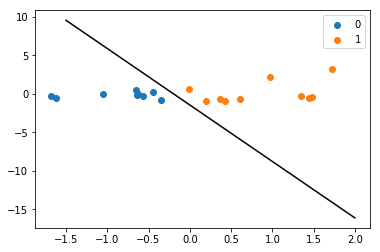

In [7]:
plt.scatter(x_train_scaled[0:9,0],x_train_scaled[0:9,1])
plt.scatter(x_train_scaled[10:20,0],x_train_scaled[10:20,1])
plt.legend(("0","1"))
#"Let's do a linear svm to seperate the datapoints"
C = 5 # SVM regularization parameter
clf = svm.SVC(kernel = 'linear',  gamma=0.7, C=C )
Y0=np.zeros((10,1))
Y1=np.ones((10,1)) 
Y=np.concatenate((Y0,Y1))
plot_svm_seperator(x_train_scaled,Y,-1,0.5,5)

### 1.3 Additional method(s)
#### 1- Region Based Descriptors
* ***Area and perimeter / Compacity and rectangularity*** 

In [8]:
#for the zeros 
area_perim_descriptors_zero=np.zeros((10,2))
area_perim_descriptors_one=np.zeros((10,2))
compacity_descriptors_zero=np.zeros((10,2))
compacity_descriptors_one=np.zeros((10,2))
i=0;
for  im, nm in zip( zeros_im, zeros_names):
    im[im>0]=1
    binary_im=im
    image_proprieties = measure.regionprops(binary_im)
    for prop in image_proprieties: 
        area_perim_descriptors_zero[i,0]=np.max(prop.area)
        area_perim_descriptors_zero[i,1]=np.max(prop.perimeter)
        compacity_descriptors_zero[i,0]=np.max(prop.perimeter**2/prop.area)
        compacity_descriptors_zero[i,1]=np.max(prop.area/prop.bbox_area )

        i+=1
i=0
for  im, nm in zip( ones_im, ones_names):
    im[im>0]=1
    binary_im=im
    image_proprieties = measure.regionprops(binary_im)
    for prop in image_proprieties: 
        area_perim_descriptors_one[i,0]=np.max(prop.area)
        area_perim_descriptors_one[i,1]=np.max(prop.perimeter) 
        compacity_descriptors_one[i,0]=np.max(prop.perimeter**2/prop.area)
        compacity_descriptors_one[i,1]=np.max(prop.area/prop.bbox_area)

        i+=1


In [9]:
prop.area

122

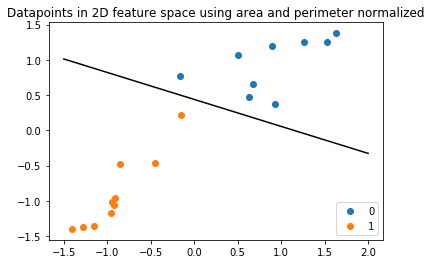

In [10]:
x_train=np.concatenate((area_perim_descriptors_zero,area_perim_descriptors_one))
x_train_scaled = preprocessing.scale(x_train)
plt.scatter(x_train_scaled[0:9,0],x_train_scaled[0:9,1])
plt.scatter(x_train_scaled[10:20,0],x_train_scaled[10:20,1])
plt.legend(("0","1"))
#"Let's do a linear svm to seperate the datapoints"
C = 10 # SVM regularization parameter
plt.title("Datapoints in 2D feature space using area and perimeter normalized")
plot_svm_seperator(x_train_scaled,Y,-1.5,2,C)

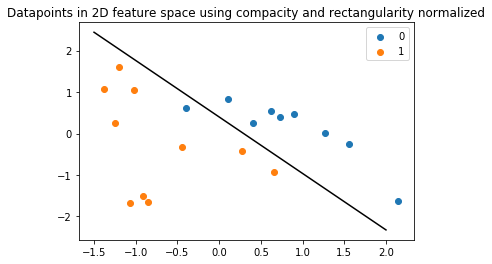

In [11]:
x_train=np.concatenate((compacity_descriptors_zero,compacity_descriptors_one))
x_train_scaled = preprocessing.scale(x_train)
plt.scatter(x_train_scaled[0:9,0],x_train_scaled[0:9,1])
plt.scatter(x_train_scaled[10:20,0],x_train_scaled[10:20,1])
plt.legend(("0","1"))
#"Let's do a linear svm to seperate the datapoints"
C = 50 # SVM regularization parameter
plt.title("Datapoints in 2D feature space using compacity and rectangularity normalized")
plot_svm_seperator(x_train_scaled,Y,-1.5,2,C)

In [12]:

FREEMAN_DICT = {-90:'4', -45:'3', 0:'2', 45:'1', 90:'0', 135:'7', 180:'6', -135:'5'}
ALLOWED_DIRECTIONS = np.array([0, 45, 90, 135, 180, -45, -90, -135])
def find_nearest(array, value):
        '''
        Find the nearest element of array to the given value
        '''
        idx = (np.abs(array-value)).argmin()
        return array[idx]
def encode_freeman(image_contour):
        '''
        Encode the image contour in an 8-direction freeman chain code based on angles
        '''
        EPSIL_DISTANCE=0.1
        freeman_code = ""
        for i in range(len(image_contour) - 1):
            delta_x = image_contour[i+1][0] - image_contour[i][0] 
            delta_y = image_contour[i+1][1] - image_contour[i][1]
            if np.abs(delta_x)<EPSIL_DISTANCE:
                delta_x=0 
            if np.abs(delta_y)<EPSIL_DISTANCE:
                delta_y=0
                
            if delta_x == 0 and delta_y == 0:
                pass
            elif delta_x > 0 and delta_y == 0:
                 freeman_code += '0'#freeman_code += '2'
            elif delta_x < 0 and delta_y == 0:
                 freeman_code += '2'#freeman_code += '6'
            elif delta_x == 0 and delta_y > 0:
                 freeman_code += '1'#freeman_code += '4'
            elif delta_x == 0 and delta_y < 0:
                 freeman_code += '3'#freeman_code += '0'
        
            elif delta_x > 0 and delta_x > np.abs(delta_y):
                freeman_code += '0'
            elif delta_x < 0 and delta_x > np.abs(delta_y):
                freeman_code += '2'
            elif delta_y < 0 and delta_y > np.abs(delta_x):
                freeman_code += '3' 
            elif delta_y > 0 and delta_y > np.abs(delta_x):
                freeman_code += '1' 
            
#             # normalize the code
#             freeman_code = self.normalize_freemancode(freeman_code)
#         print freeman_code
#         print image_contour[0],image_contour[1],image_contour[2] 
#         plt.imshow(image_array)
#         plt.show()
        
        return freeman_code

In [13]:
def EditDistance(freeman_code1, freeman_code2):
    # For all i and j, d[i,j] will hold the Levenshtein distance between
    # the first i characters of s and the first j characters of t.
    # Note that d has (m+1) x (n+1) values.
    #let d be a 2-d array of int with dimensions [0..m, 0..n]
    freeman_code1='-1'+freeman_code1 #first element not taken into account
    freeman_code2='-1'+freeman_code2 # first element not taken into account
    d=np.zeros((len(freeman_code1)+1,len(freeman_code2)+1),dtype="uint16")
    for i in range(len(freeman_code1)):
        d[i, 0] = i 
        #// the distance of any first string to an empty second string
        #// (transforming the string of the first i characters of s into
        #// the empty string requires i deletions)
    for j in range(len(freeman_code2)):
        d[0, j] = j 
        #// the distance of any second string to an empty first string
  
    for j in range(1,len(freeman_code2)):
        for i in range(1,len(freeman_code1)):
            if freeman_code1[i] == freeman_code2[j] : 
                d[i, j] = d[i-1, j-1]       
                #// no operation required
            else:
                d[i, j] = min( d[i-1, j] + 1,d[i, j-1] + 1,d[i-1, j-1] + 1) 
  
    return d[len(freeman_code1)-1,len(freeman_code2)-1]

In [22]:
        
#         contours = measure.find_contours(image_array, 0.9, positive_orien
im=zeros_im[0] # Just take the first zero image as a reference for others
im[im>0]=1
binary_im=im
# _, contours, hierarchy = cv2.findContours(binary_im,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
contours_ref_zero = measure.find_contours(binary_im, 0.9, positive_orientation='high')
contours_ref_zero = max(contours_ref_zero, key=len)
freemancode_ref_zero=encode_freeman(contours_ref_zero)
feature_freeman=np.zeros((20,2))

im=ones_im[0] # Just take the first zero image as a reference for others
im[im>0]=1
binary_im=im
# _, contours, hierarchy = cv2.findContours(binary_im,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
contours_ref_one = measure.find_contours(binary_im, 0.9, positive_orientation='high')
contours_ref_one = max(contours_ref_one, key=len)
freemancode_ref_one=encode_freeman(contours_ref_one)
i=0
for  im, nm in zip( zeros_im, zeros_names):
    im[im>0]=1
    binary_im=im
    # _, contours, hierarchy = cv2.findContours(binary_im,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    contours = measure.find_contours(binary_im, 0.9, positive_orientation='high')
    contours_main = max(contours, key=len)
    freeman_code=encode_freeman(contours_main)
    edit_distance=EditDistance(freeman_code,freemancode_ref_zero)
    feature_freeman[i,0]=edit_distance
    edit_distance=EditDistance(freeman_code,freemancode_ref_one)
    feature_freeman[i,1]=edit_distance
    i=i+1

for  im, nm in zip( ones_im, ones_names):
    im[im>0]=1
    binary_im=im
    # _, contours, hierarchy = cv2.findContours(binary_im,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    contours = measure.find_contours(binary_im, 0.9, positive_orientation='high')
    contours_main = max(contours, key=len)
    freeman_code=encode_freeman(contours_main)
    edit_distance=EditDistance(freeman_code,freemancode_ref_one)
    feature_freeman[i,1]=edit_distance
    edit_distance=EditDistance(freeman_code,freemancode_ref_zero)
    feature_freeman[i,0]=edit_distance
    i=i+1

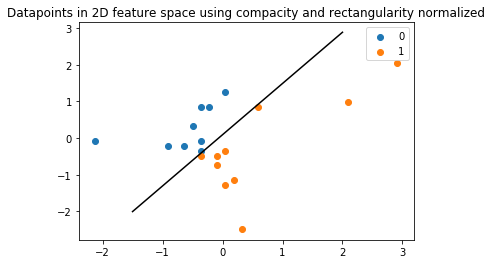

In [23]:
x_train_scaled = preprocessing.scale(feature_freeman)
plt.scatter(x_train_scaled[0:9,0],x_train_scaled[0:9,1])
plt.scatter(x_train_scaled[10:20,0],x_train_scaled[10:20,1])
plt.legend(("0","1"))
C = 10000 # SVM regularization parameter
plt.title("Datapoints in 2D feature space using compacity and rectangularity normalized")
plot_svm_seperator(x_train_scaled,Y,-2,3,C)

In [24]:
import cv2
import numpy as np
img=im
size = np.size(img)
skel = np.zeros(img.shape,np.uint8)
 
img=im
element = cv2.getStructuringElement(cv2.MORPH_CROSS,(2,2))
done = False
i = 0
while( not done and i<1000):
    eroded = cv2.erode(img,element)
    temp = cv2.dilate(eroded,element)
    temp = cv2.subtract(img,temp)
    skel = cv2.bitwise_or(skel,temp)
    img = eroded.copy()
 
    zeros = size - cv2.countNonZero(img)
    i += 1
    if zeros==size:
        done = True
cv2.imshow("skel",skel)

Let's try line and cercle hough transform 

In [109]:
#for the zeros 
feature_descriptors_zero=np.zeros((10,2))
feature_descriptors_one=np.zeros((10,2))
i=0;
#fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
feature_hough=np.zeros((20,2)) 

for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    im[im>0]=1
    binary_im=im
    # cercle
    hough_res=transform.hough_circle(binary_im,np.arange(7,9,1))
    #accum,cx,cy,radii=transform.hough_circle_peaks(hough_res,np.arange(7,9,1),total_num_peaks=1
    feature_hough[i,0]=(hough_res.max()+ )/hough_res.sum()
    
    #line
    hough_line,angle,dist=transform.hough_line(binary_im)
    #hough_line_peak=transform.hough_line_peaks(hough_line,angle, dist, num_peaks = 1)
    feature_hough[i,1]=hough_line.max()/hough_line.sum()
    """" 
    image = skimage.color.gray2rgb(im)
    for center_y,center_x,radius in zip(cy,cx,radii):
        ciry,cirx=skimage.draw.circle_perimeter(center_y,center_x,radius)
        image[ciry,cirx]=(200,20,20)
    ax.imshow(image, cmap=plt.cm.gray)
    ax.axis('off')
    ax.set_title(nm)
    """
    i=i+1
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    im[im>0]=1
    binary_im=im
    #Circle
    hough_res=transform.hough_circle(binary_im,np.arange(6,8,1))
    #accum,cx,cy,radii=transform.hough_circle_peaks(hough_res,np.arange(6,8,1),total_num_peaks=1)
    feature_hough[i,0]=hough_res.max()/hough_res.sum()
    
    #line
    hough_line,angle,dist=transform.hough_line(binary_im)
    #hough_line_peak=transform.hough_line_peaks(hough_line,angle, dist, num_peaks = 1)
    feature_hough[i,1]=hough_line.max()/hough_line.sum()
    """"
    image = skimage.color.gray2rgb(im)
    for center_y,center_x,radius in zip(cy,cx,radii):
        ciry,cirx=skimage.draw.circle_perimeter(center_y,center_x,radius)
        image[ciry,cirx]=(200,20,20)
    ax.imshow(image, cmap=plt.cm.gray)
    ax.axis('off')
    ax.set_title(nm)
    """
    i=i+1
#plt.show()

In [121]:
hough_line.shape

(80, 180)

In [110]:
hough_line_peak

(array([21], dtype=uint64), array([0.21938496]), array([16.70886076]))

In [111]:
feature_hough

array([[0.00247617, 0.00089606],
       [0.0025746 , 0.00085227],
       [0.00277352, 0.00078563],
       [0.00202827, 0.00081967],
       [0.00207982, 0.00077778],
       [0.00246066, 0.00064103],
       [0.00262266, 0.00058346],
       [0.00215866, 0.00071759],
       [0.00309162, 0.00068438],
       [0.00231257, 0.00068134],
       [0.00246227, 0.00144676],
       [0.00226319, 0.00131422],
       [0.00250772, 0.00171569],
       [0.00262024, 0.00155556],
       [0.002474  , 0.00146199],
       [0.00251483, 0.00083933],
       [0.00239617, 0.00142276],
       [0.00251245, 0.00147754],
       [0.00250198, 0.00129068],
       [0.00236305, 0.00095628]])

In [122]:
houg_line.max()

30

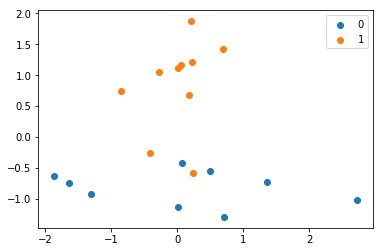

In [115]:
x_train_scaled = preprocessing.scale(feature_hough)
plt.scatter(x_train_scaled[0:9,0],x_train_scaled[0:9,1])
plt.scatter(x_train_scaled[10:20,0],x_train_scaled[10:20,1])
plt.legend(("0","1"))